In [4]:
import networkx as nx
import cirq
import cirq_google
import numpy as np
from matplotlib import pyplot as plt

In [7]:
class Gate:
    def __init__(self, gname, *args):
        self.name = gname
        self.qs = []
        for i in args:
            self.qs.append(i)
        if self.name != "":
            self.gate = getattr(cirq, self.name)

def choose_oneq_gates(gates, depth):
    #Chooses one one-qubit gate from given for each step in range(depth)
    ans = []
    probs = [len(gates) for i in range(len(gates))]
    for i in range(depth):
        gate = np.random.choice(gates, p = np.array([1. / i for i in probs]) / sum([1. / i for i in probs]))
        probs[gates.index(gate)] += len(gates)
        ans.append(gate)
    return ans

def choose_qubits_for_CZ(depth, num_q):
    #Chooses qubits to apply CZ to for each step in range(depth)
    ans = []
#     if num_q == 2:
#         vrs = [[0], []]
#         probs = [2 for i in range(2)]
#     elif num_q == 3:
#         vrs = [[0], [1]]
#         probs = [2 for i in range(2)]
#     elif num_q == 4:
#         vrs = [[0, 2], [1]]
#         probs = [2 for i in range(2)]
#     elif num_q == 5:
#         vrs = [[0, 2], [0, 3], [1, 3]]
#         probs = [3 for i in range(3)]
#     ans = []
#     for i in range(depth):
#         qs = np.random.choice([i for i in range(len(probs))], p = np.array([1. / i for i in probs]) / sum([1. / i for i in probs]))
#         probs[qs] += len(vrs)
#         ans.append(np.array(vrs[qs]))
    odds = [i for i in range(num_q - 1) if i % 2 == 1]
    evens = [i for i in range(num_q - 1) if i % 2 == 0]
    vrs = [odds, evens]
    probs = [2 for i in range(2)]
    for i in range(depth):
        qs = np.random.choice([i for i in range(len(probs))], p = np.array([1. / i for i in probs]) / sum([1. / i for i in probs]))
        probs[qs] += len(vrs)
        ans.append(np.array(vrs[qs]))
    return ans

### Generate Gate Sequence

In [8]:
num_q = 5
depth = 3

oneq_gates = ["T", "rx", "ry"]
seq_oneq_gates = choose_oneq_gates(oneq_gates, depth)
seq_cz_qubits = choose_qubits_for_CZ(depth, num_q)

gates = []
nodes = []

for i in range(num_q):
    gates.append(Gate("H", i))
    nodes.append((i, {"subset" : 0}))

cnt = num_q
for i in range(depth):
    for v in range(num_q):
        if v in seq_cz_qubits[i]:
            gates.append(Gate("CZ", v, v + 1))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1
        elif v not in seq_cz_qubits[i] and v not in seq_cz_qubits[i] + 1:
            gates.append(Gate(""))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1

    for j in range(num_q):
        gates.append(Gate(seq_oneq_gates[i], j))
        nodes.append((cnt, {"subset" : 2 * i + 2}))
        cnt += 1

In [9]:
# for g in gates:
#     print(g.name, g.qs)

### Create Graph

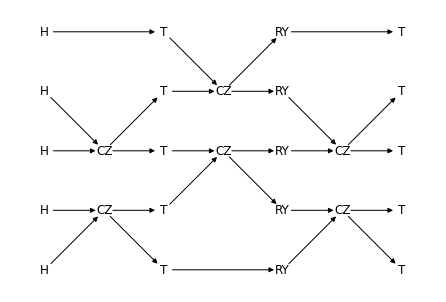

In [10]:
G = nx.DiGraph()
G.add_nodes_from(nodes)

cur_gate = np.array([i for i in range(num_q)])
cur = num_q
for gate in gates[num_q:]:
    for i in gate.qs:
        G.add_edge(cur_gate[i], cur)
        cur_gate[i] = cur
    cur += 1
    
pos = nx.multipartite_layout(G)
labeldict = {}
for i in range(len(gates)):
    labeldict[i] = gates[i].name.upper()
nx.draw(G, pos, labels = labeldict, with_labels = True, node_color = 'none')

### Simulate on LineQubit

In [17]:
q_line = cirq.LineQubit.range(num_q)
line_circuit = cirq.Circuit()

for gate in gates:        
    if len(gate.qs) == 1 and gate.name[0] != 'r':
        line_circuit.append(gate.gate(q_line[gate.qs[0]]))
    elif len(gate.qs) == 1:
        line_circuit.append(gate.gate(np.pi / 2)(q_line[gate.qs[0]]))
    elif len(gate.qs) == 2:
        line_circuit.append(gate.gate(q_line[gate.qs[0]], q_line[gate.qs[1]]))
print(line_circuit)
#barier

0: ───H───T───────@──────────Ry(0.5π)───T───────
                  │
1: ───H───@───T───@──────────Ry(0.5π)───@───T───
          │                             │
2: ───H───@───T───@──────────Ry(0.5π)───@───T───
                  │
3: ───H───@───T───@──────────Ry(0.5π)───@───T───
          │                             │
4: ───H───@───T───Ry(0.5π)──────────────@───T───


In [12]:
sim = cirq.Simulator()
results_line = sim.simulate(line_circuit)
print(results_line)

measurements: (no measurements)
output vector: [-0.1325825 +0.01830581j  0.19508249-0.08080581j  0.01830581-0.08080582j
 -0.23169412-0.04419418j -0.23169413-0.08080582j -0.01830582+0.04419415j
  0.10669414+0.16919412j -0.13258247-0.0700825j   0.01830581-0.08080581j
 -0.19508249-0.13258249j -0.14330578+0.16919413j  0.04419417+0.10669415j
 -0.10669416-0.16919413j  0.04419415-0.14330578j -0.13258249+0.10669414j
 -0.16919413-0.0700825j   0.19508249-0.0808058j   0.10669414-0.0808058j
 -0.19508247-0.1325825j   0.04419417-0.07008252j -0.01830582+0.04419417j
 -0.22097082-0.10669415j -0.04419418+0.14330578j  0.04419417+0.19508249j
  0.23169412+0.04419415j -0.04419416+0.07008251j -0.04419417-0.10669414j
  0.22097081+0.01830583j -0.13258247-0.0700825j   0.04419415+0.19508249j
  0.16919413+0.0700825j  -0.0183058 -0.16919413j]


### Simulate with Swaps

In [18]:
q_cross = []
#В начале в центре первый кубит (можем применять CZ на пары (0,1) и (1,2)), при необходимости меняем его и третий (получаем оставшиеся пары (2,3) и (3,4))
q_cross.append(cirq.GridQubit(0, 1))    #qubit 0
q_cross.append(cirq.GridQubit(1, 1))    #qubit 1
q_cross.append(cirq.GridQubit(1, 0))    #qubit 2
q_cross.append(cirq.GridQubit(1, 2))    #qubit 3
q_cross.append(cirq.GridQubit(2, 1))    #qubit 4

cross_circuit = cirq.Circuit()
current = 1

for gate in gates:        
    if len(gate.qs) == 1 and gate.name[0] != 'r':
        cross_circuit.append(gate.gate(q_cross[gate.qs[0]]))
    elif len(gate.qs) == 1:
        cross_circuit.append(gate.gate(np.pi / 2)(q_cross[gate.qs[0]]))
    elif len(gate.qs) == 2:
        if 3 in gate.qs and current == 1:
            qb = gate.qs[1 - gate.qs.index(3)]
            cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[3]))
            current = 3
        elif 1 in gate.qs and current == 3:
            qb = gate.qs[1 - gate.qs.index(1)]
            cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[3]))
            current = 1
        else:
            qb = gate.qs[1 - gate.qs.index(current)]
        cross_circuit.append(gate.gate(q_cross[1], q_cross[qb]))
if current == 3:
    cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[3]))
cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[2]))
print(cross_circuit)

                       ┌──┐                                                                   ┌──┐
(0, 1): ───H───T─────────────────────────────@───Ry(0.5π)───T────────────────────────────────────────────────────
                                             │
(1, 0): ───H───@───T─────────────────────────┼──────────────@──────────Ry(0.5π)───────@───T──────────────────×───
               │                             │              │                         │                      │
(1, 1): ───H───@───×────@─────T───×──────────@───×──────────@──────────Ry(0.5π)───×───@───×────@─────T───×───×───
                   │    │         │              │                                │       │    │         │
(1, 2): ───H───────×────┼T────────×──────────────×──────────Ry(0.5π)──────────────×───────×────┼T────────×───────
                        │                                                                      │
(2, 1): ───H────────────@─────T───Ry(0.5π)─────────────────────────────────────────

In [14]:
sim_cross = cirq.Simulator()
results_cross = sim_cross.simulate(cross_circuit)
print(results_cross)

measurements: (no measurements)
output vector: [-0.13258249+0.01830582j  0.19508246-0.08080581j  0.01830583-0.08080581j
 -0.2316941 -0.04419416j -0.2316941 -0.0808058j  -0.01830583+0.04419416j
  0.10669413+0.16919413j -0.13258249-0.07008249j  0.01830583-0.08080579j
 -0.19508246-0.13258249j -0.14330576+0.16919412j  0.04419416+0.10669415j
 -0.10669415-0.16919412j  0.04419417-0.14330578j -0.13258246+0.10669412j
 -0.16919413-0.0700825j   0.19508246-0.0808058j   0.10669412-0.0808058j
 -0.19508247-0.13258247j  0.04419417-0.07008249j -0.01830581+0.04419417j
 -0.22097076-0.10669412j -0.04419417+0.14330578j  0.04419418+0.19508246j
  0.2316941 +0.04419417j -0.04419415+0.0700825j  -0.04419415-0.10669412j
  0.22097081+0.01830582j -0.13258247-0.07008249j  0.04419418+0.19508246j
  0.16919412+0.0700825j  -0.01830581-0.16919412j]


### Results comparison

In [15]:
np.round(results_line.final_state_vector - results_cross.final_state_vector, 3)
#Результаты одинаковые

array([-0.-0.j,  0.+0.j, -0.-0.j, -0.-0.j, -0.-0.j,  0.-0.j,  0.-0.j,
        0.-0.j, -0.-0.j, -0.+0.j, -0.+0.j,  0.+0.j, -0.-0.j, -0.+0.j,
       -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.-0.j,  0.-0.j, -0.-0.j,
       -0.-0.j, -0.+0.j, -0.+0.j,  0.-0.j, -0.+0.j, -0.-0.j,  0.+0.j,
        0.-0.j, -0.+0.j,  0.+0.j,  0.-0.j], dtype=complex64)